# Installing & Importing everything needed

In [1]:
!pip uninstall torch torchvision torchaudio torchtext -y
!pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install torchtext==0.13.1

Found existing installation: torch 1.12.1+cu116
Uninstalling torch-1.12.1+cu116:
  Successfully uninstalled torch-1.12.1+cu116
Found existing installation: torchvision 0.13.1+cu116
Uninstalling torchvision-0.13.1+cu116:
  Successfully uninstalled torchvision-0.13.1+cu116
Found existing installation: torchaudio 0.12.1+cu116
Uninstalling torchaudio-0.12.1+cu116:
  Successfully uninstalled torchaudio-0.12.1+cu116
Found existing installation: torchtext 0.13.1
Uninstalling torchtext-0.13.1:
  Successfully uninstalled torchtext-0.13.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
  Using cached https://download.pytorch.org/whl/cu116/torch-1.12.1%2Bcu116-cp310-cp310-linux_x86_64.whl (1904.8 MB)
  Using cached https://download.pytorch.org/whl/cu116/torchvision-0.13.1%2Bcu116-cp310-cp310-linux_x86_64.whl (23.5 MB)
  Using cached https://download.pytorch.org/whl/cu116/torchaudio-0.12.1%2Bcu116-cp310-cp31

In [2]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install comet_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import comet_ml

import os

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms, datasets
import torch.nn as nn

import torch.distributions.bernoulli

import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint

from PIL import Image
import matplotlib.pyplot as plt

# Defining our Model

In [118]:
class invertColor():
    """
    Is used to inverse the color of a dataset when this dataset is in range[0;1]
    """
    def __call__(self, img):
        return self.invert(img)

    def invert(self, img):
        return 1 - img

In [119]:
class randomBlackToWhite():
    """
    Is used to transform some white pixels of the digit in black pixel
    """
    def __init__(self, prob):
      self.prob = prob

    def __call__(self, img):
        return self.randomBlackToWhite(img)

    def randomBlackToWhite(self, img, prob=0.9):
        return img * torch.distributions.bernoulli.Bernoulli(torch.tensor([self.prob])).sample(img.shape).squeeze(-1)

In [151]:
class CNN(pl.LightningModule):
    def __init__(self, compose):
        super().__init__()
        self.batch_size = batch_size
        self.lr = lr
        self.ndf = ndf

        self.val_correct_counter = 0
        self.val_total_counter = 0

        self.compose = compose

        self.save_hyperparameters()

        self.hidden0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.ndf, kernel_size=4),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2)
        )

        self.hidden1 = nn.Sequential(
            nn.Conv2d(self.ndf, self.ndf * 4, kernel_size=4),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2)
        )

        self.hidden2 = nn.Sequential(
            nn.Conv2d(self.ndf * 4, self.ndf, kernel_size=4),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2)
        ) 

        self.hidden3 = nn.Sequential(
            nn.Linear(5776, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(0.2)
        )

        # self.hidden4 = nn.Sequential(
        #     nn.Linear(1000, 200),
        #     nn.LeakyReLU(0.2)
        # )

        self.hidden4 = nn.Sequential(
            nn.Linear(200, 10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)

        x = torch.flatten(x, start_dim=1, end_dim=-1)

        x = self.hidden3(x)
        #x = self.hidden4(x)
        x = self.hidden4(x)

        return x

    def cross_entropy_loss(self, predicted_label, label):
        return nn.CrossEntropyLoss()(predicted_label, label)

    def training_step(self, batch, batch_idx):
        x, y = batch

        predicted = self.forward(x)
        loss = self.cross_entropy_loss(predicted, y)
        acc = (predicted.argmax(dim=-1) == y).float().mean() # logs train acc per epoch

        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True)
        self.log("train_loss", loss, logger=True, sync_dist=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch

        predicted = self.forward(x)
        loss = self.cross_entropy_loss(predicted, y)
        acc = (predicted.argmax(dim=-1) == y).float().mean() # logs train acc per epoch

        self.log("val_acc", acc, on_step=False, on_epoch=True, logger=True)
        self.log("val_loss", loss, logger=True)


    def test_step(self, test_batch, batch_idx):
        x, y = test_batch

        predicted = self.forward(x)
        loss = self.cross_entropy_loss(predicted, y)
        acc = (predicted.argmax(dim=-1) == y).float().mean() # logs train acc per epoch

        self.log("test_acc", acc, on_step=False, on_epoch=True, logger=True)
        self.log("test_loss", loss)

    def prepare_data(self):
        self.mnist_train = datasets.MNIST(
            root="data",
            train=True,
            download=True,
            transform=self.compose
        )

        self.mnist_test = datasets.MNIST(
            root="data",
            train=False,
            download=True,
            transform=self.compose
        )

        self.mnist_train, self.mnist_val = torch.utils.data.random_split(self.mnist_train, [55000, 5000])

    def train_dataloader(self):
        mnist_train_loader = torch.utils.data.DataLoader(self.mnist_train,
                                                         batch_size=self.batch_size,
                                                         num_workers=1,
                                                         shuffle=True)

        return mnist_train_loader

    def val_dataloader(self):
        mnist_val_loader = torch.utils.data.DataLoader(self.mnist_val,
                                                         batch_size=self.batch_size,
                                                         num_workers=1,
                                                         shuffle=True)

        return mnist_val_loader

    def test_dataloader(self):
        mnist_test_loader = torch.utils.data.DataLoader(self.mnist_test,
                                                       batch_size=self.batch_size,
                                                       num_workers=1,
                                                       shuffle=True)

        return mnist_test_loader

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [152]:
compose = transforms.Compose([
    transforms.RandomCrop(28, padding=8, pad_if_needed=True, fill=1, padding_mode='edge'),
    transforms.ToTensor(),
    randomBlackToWhite(0.7),
    invertColor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [153]:
# Parameters
experiment_name = "RN_RC_BN"
dataset_name = "MNIST_inv_color"
tags = ["CNN", "Inverted_MNIST", "RandomNoise", "RandomCrop", "Batchnorm"]
lr = 0.001
batch_size = 1024
ndf = 16
seed = 42

checkpoint_folder = "./" + experiment_name + "_checkpoints/"

In [154]:
# Downloading MNIST Data
train_ds = MNIST(
    "data", train=True, download=True, transform=compose
)

# Training our Model

In [155]:
# get the api key
with open("api_key.txt", "r") as f:
    f_api_key = f.read()

In [156]:
# set global seed
torch.manual_seed(seed)

# init logger
comet_logger = loggers.CometLogger(
    api_key= f_api_key,
    project_name="mnist-proseminar",
    experiment_name=experiment_name,
)

#defining net
net = CNN(compose)

#logging 
comet_logger.experiment.set_model_graph(str(net))
comet_logger.experiment.add_tags(tags=tags)
comet_logger.experiment.log_dataset_info(name=dataset_name)
comet_logger.experiment.log_parameter(name="learning_rate", value=lr)
comet_logger.experiment.log_parameter(name="batch_size", value=batch_size)
comet_logger.experiment.log_parameter(name="ndf", value=ndf)
comet_logger.experiment.log_parameter(name="seed", value=seed)

INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/luposx/mnist-proseminar/af47ec0a1af7494396c7b66649bbb93d



In [157]:
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_folder, filename=experiment_name+"-{epoch}")
trainer = pl.Trainer(# fast_dev_run=True,
                      callbacks=checkpoint_callback,
                      accelerator="gpu",
                      max_epochs=5,
                      logger=comet_logger)
trainer.fit(net)

# saving our model
data_test = next(iter(train_ds))[0]
data_test = data_test.view(1, 1, 28, 28)
net.to_onnx(checkpoint_folder + "/" + experiment_name + "_last_epoch.onx", data_test, export_params=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | hidden0 | Sequential | 304   
1 | hidden1 | Sequential | 16.6 K
2 | hidden2 | Sequential | 16.4 K
3 | hidden3 | Sequential | 1.2 M 
4 | hidden4 | Sequential | 2.0 K 
---------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.764     Total estimated model params size (MB)
COMET WARNING: Set model graph ignored; already called. Call with overwrite=True to replace graph definition


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/luposx/mnist-proseminar/af47ec0a1af7494396c7b66649bbb93d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [27]      : (1.5548558235168457, 2.303624153137207)
COMET INFO:     train_acc [5]  : (0.5006909370422363, 0.9103090763092041)
COMET INFO:     train_loss [5] : (1.5754667520523071, 1.84124755859375)
COMET INFO:     val_acc [5]    : (0.43140000104904175, 0.8787999749183655)
COMET INFO:     val_loss [5]   : (1.6018280982971191, 2.0286035537719727)
COMET INFO:   Others:
COMET INFO:     Name         : RN_RC_BN
COMET INFO:     d

In [158]:
# log checkpoints
comet_logger.experiment.log_asset_folder(folder=checkpoint_folder)
comet_logger.experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/luposx/mnist-proseminar/af47ec0a1af7494396c7b66649bbb93d

COMET WARNING: The default value for the log_file_name parameter will change from False to True in a future version. Explicitly pass log_file_name=True or log_file_name=False to disable this warning
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https

# Inference

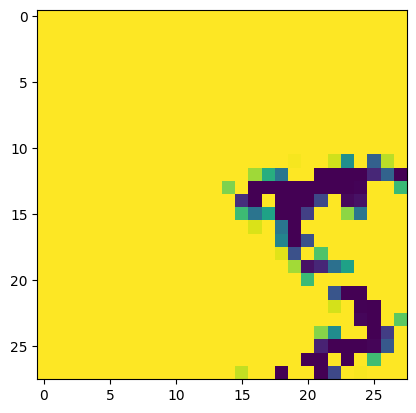

In [140]:
# loading a sample dat
data = next(iter(train_ds))[0]
plt.imshow(data.permute(1, 2, 0))

In [141]:
# We need one extra dimesnion to emulate batch size.
data = data.view(1, 1, 28, 28)

model = net.load_from_checkpoint(checkpoint_folder + "/1L_RN_RC-epoch=4.ckpt")
model.eval()

CNN(
  (hidden0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Conv2d(16, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Conv2d(64, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden3): Sequential(
    (0): Linear(in_features=5776, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden4): Sequential(
    (0): Linear(in_features=200, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [142]:
with torch.no_grad():
   y_hat = model(data.cuda())

print("Results for Inference")
print("---------------------------")
print(" ")
print("Probabilities for Predicted-Labels: ", y_hat)
print(" ")
print("Predicted Label: ", y_hat.argmax())

Results for Inference
---------------------------
 
Probabilities for Predicted-Labels:  tensor([[5.5449e-06, 4.1125e-14, 5.8090e-02, 9.0073e-01, 2.6996e-09, 4.0045e-02,
         2.2466e-11, 1.1228e-03, 2.7172e-06, 3.7667e-06]], device='cuda:0')
 
Predicted Label:  tensor(3, device='cuda:0')
